In [1]:
input_data = "input/train.csv"

In [2]:
from datetime import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv(input_data)
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
target = df['SalePrice'].copy()
df.drop(['Id'], axis = 1, inplace = True)

In [5]:
# Features with missing values
missing_val_cols = df.columns[df.isnull().any()]
missing_val_cols

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [6]:
# % of missing values in each feature
for col in missing_val_cols:
    missing_val_count = df[col].isnull().sum()
    print(col, "  ", missing_val_count, " == %.2f" % (missing_val_count/df.shape[0]))

LotFrontage    259  == 0.18
Alley    1369  == 0.94
MasVnrType    8  == 0.01
MasVnrArea    8  == 0.01
BsmtQual    37  == 0.03
BsmtCond    37  == 0.03
BsmtExposure    38  == 0.03
BsmtFinType1    37  == 0.03
BsmtFinType2    38  == 0.03
Electrical    1  == 0.00
FireplaceQu    690  == 0.47
GarageType    81  == 0.06
GarageYrBlt    81  == 0.06
GarageFinish    81  == 0.06
GarageQual    81  == 0.06
GarageCond    81  == 0.06
PoolQC    1453  == 1.00
Fence    1179  == 0.81
MiscFeature    1406  == 0.96


#### Dropping the columns Alley, PoolQC, MiscFeature and Fence ans more than 80% values are missing in them

In [7]:
drop_list = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
df = df.drop(drop_list, axis = 1)

In [8]:
missing_val_cols = [col for col in missing_val_cols if col not in drop_list]

In [9]:
# checking if all the values in a record are missing
df.isnull().all(axis = 1).any()

False

#### Handling missing values in FireplaceQu

In [10]:
# For the records with missing values set a new category of 'UNK'
df['FireplaceQu'] = df['FireplaceQu'].fillna('UNK')
missing_val_cols.remove('FireplaceQu')

#### Handling missing values in Electrical

In [11]:
df['Electrical'] = df['Electrical'].fillna(method = 'ffill')
missing_val_cols.remove('Electrical')

#### Handling missing values in LotFrontage

Onto multivariate analysis. There are a few key features that I suspect will influence LotFrontage:

    LotArea - Clearly should have a significant correlation with LotFrontage. This relationship would not be linear, but some 2nd degree polynomial. If all lots were exactly square, then LotFrontage=sqrt(LotArea)


LotConfig - Corner unit will likely have a larger LotFrontage than Inside lots. Similarly, CulDSac will have a circular shape of its LotFrontage.

LotShape - Regular and irregular lots likely have different relationships between LotFrontage and LotArea.

MSZoning - High and low density residentials zones may have different LotFrontage values.

BldgType - Townhouse has a much more narrow footprint than a detached house. This should affect LotFrontage 
quite a bit.

Neighborhood - Different parts of the city may have different standard for LotArea and LotFrontage.
Condition1 & Condition2 - Can serve as markers for lot location within the neighbourhood (e.g. lots within same block are similar in size and LotFrontage)

GarageType - Garage must have direct access to street, which should influence LotFrontage. Unless of course the garage is facing the alley.

GarageCars - Number of cars that fit in the garage will also affect the Lot Frontage, similar to GarageType.

In [12]:
pot_cols = ['LotArea', 'LotConfig', 'LotShape', 'MSZoning', 'BldgType', 'Neighborhood', 'Condition1', 'Condition2', 'GarageCars']
lf_train_y = df.loc[~df['LotFrontage'].isnull(), 'LotFrontage']
lf_train = df.loc[~df['LotFrontage'].isnull(), pot_cols]
lf_test = df.loc[df['LotFrontage'].isnull(), pot_cols]

In [13]:
# Converting categorical into dummies and normalizing the data
lf_train = pd.get_dummies(lf_train)
lf_train = (lf_train - lf_train.mean())/lf_train.std()
lf_train.fillna(0, inplace = True)

In [14]:
clf = svm.SVR(C=100, gamma='auto')
kf = KFold(n_splits=10, shuffle=True, random_state=0) 
acc = 0
for i, (train, test) in enumerate(kf.split(lf_train)):
    clf.fit(lf_train.iloc[train, :], lf_train_y.iloc[train])
    acc += mean_absolute_error(lf_train_y.iloc[test], clf.predict(lf_train.iloc[test]))
    print("fold {} cross validation MAE is {:.3}".format(i, acc/10))

fold 0 cross validation MAE is 0.878
fold 1 cross validation MAE is 1.72
fold 2 cross validation MAE is 2.76
fold 3 cross validation MAE is 3.68
fold 4 cross validation MAE is 4.46
fold 5 cross validation MAE is 5.62
fold 6 cross validation MAE is 6.47
fold 7 cross validation MAE is 7.42
fold 8 cross validation MAE is 8.29
fold 9 cross validation MAE is 9.15


In [15]:
# prediction over missing values
lf_test = pd.get_dummies(lf_test)
lf_test = (lf_test - lf_test.mean())/lf_test.std()
lf_test = lf_test.fillna(0)

In [16]:
for col in (set(lf_train.columns) - set(lf_test.columns)):
    lf_test[col] = 0
lf_test = lf_test[lf_train.columns]

In [17]:
df.loc[df['LotFrontage'].isnull(), 'LotFrontage'] = clf.predict(lf_test)
missing_val_cols.remove('LotFrontage')

#### Handling missing values in GarageYrBlt

In [18]:
# Being a discrete variable with 6% of missing I'll be imputing with the mode of the variable
mode = df.loc[~df['GarageYrBlt'].isnull(), 'GarageYrBlt'].mode()
missing_inds = np.where(df['GarageYrBlt'].isnull())[0]
df.loc[missing_inds, 'GarageYrBlt'] = np.int(mode)
missing_val_cols.remove('GarageYrBlt')

In [19]:
# Rest of these features have very few missing values. So lets impute those missig values with 
# mean for numeric variables 
# UNK tag for categorical variables
num_features = df[missing_val_cols].select_dtypes(include=np.number).columns.tolist()
cat_features = df[missing_val_cols].select_dtypes(exclude=np.number).columns.tolist()
for col in missing_val_cols:
    missing_inds = np.where(df[col].isnull())[0]
    if col in cat_features:
        df.loc[missing_inds, col] = 'UNK'
    else:
        df.loc[missing_inds, col] = 0

In [20]:
# check missing values
df[missing_val_cols].isnull().any()

MasVnrType      False
MasVnrArea      False
BsmtQual        False
BsmtCond        False
BsmtExposure    False
BsmtFinType1    False
BsmtFinType2    False
GarageType      False
GarageFinish    False
GarageQual      False
GarageCond      False
dtype: bool

In [21]:
# Confirming missing values in whole data
df.isnull().any().any()

False

#### Separating Columns based on the feature datatype

In [22]:
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

In [23]:
df[numeric_cols].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [24]:
discrete_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
# We can convert the year variable into age by counting the number of year till today's year
def year_to_age(series):
    today_year = datetime.now().year
    return today_year - series
for col in discrete_cols:
    df[col] = year_to_age(df[col])

#### Checking correlation in numeric variables

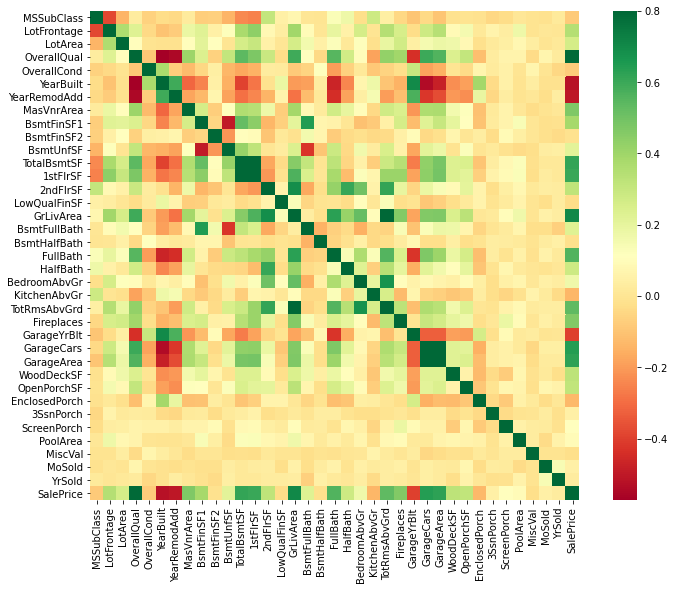

In [25]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="RdYlGn");

In [26]:
# Identifying variables that are highly correlated with the target variable

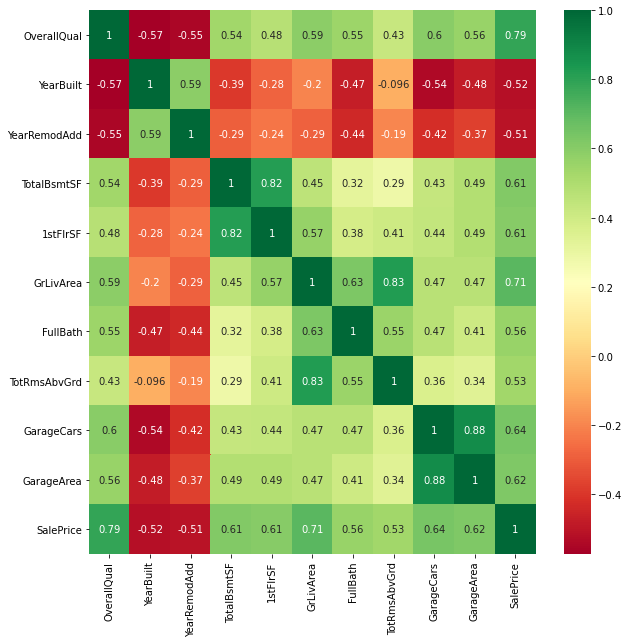

In [27]:
corrmat = df.corr()
top_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(df[top_features].corr(),annot=True,cmap="RdYlGn")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


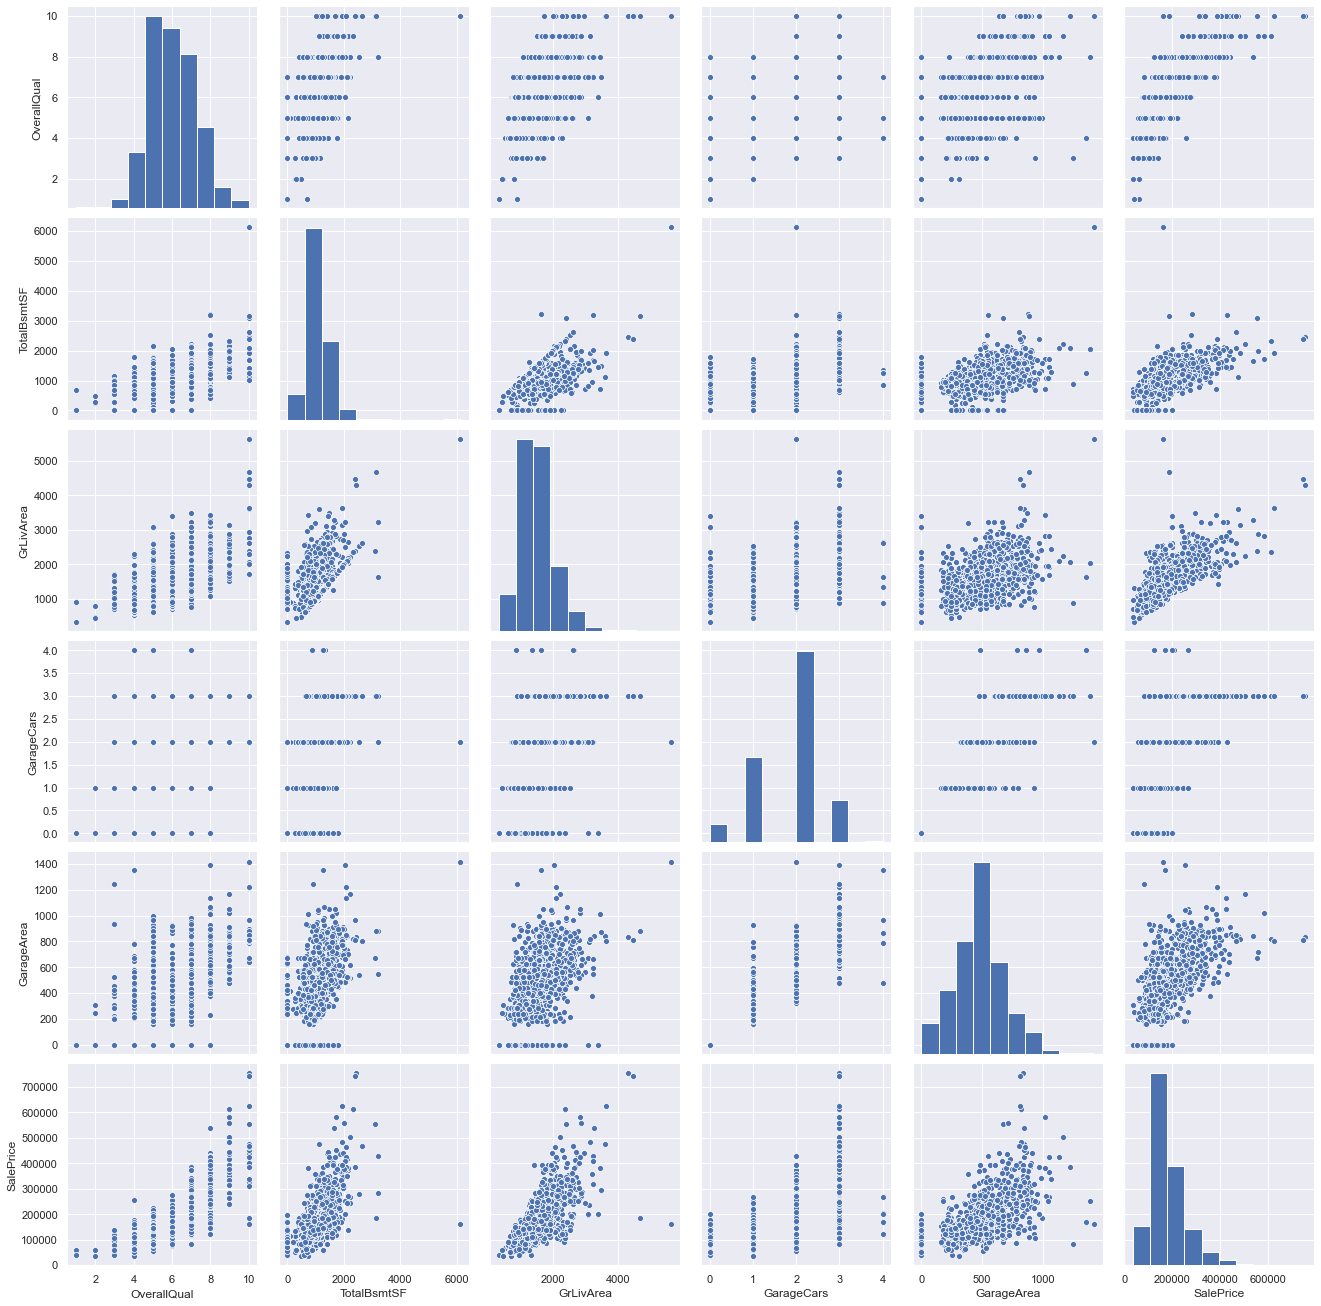

In [28]:
#scatterplot
sns.set()
sns.pairplot(df[['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'GarageArea', 'SalePrice']], size = 3)
plt.show();

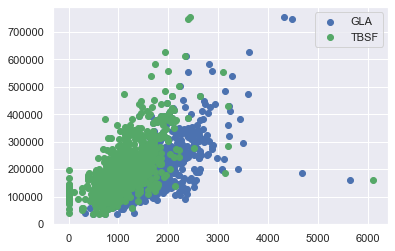

In [29]:
# Outliers in GrLivArea and TotalBsmtSF
plt.scatter(df.GrLivArea, df.SalePrice, c = 'b', label = 'GLA')
plt.scatter(df.TotalBsmtSF, df.SalePrice, c = 'g', label = 'TBSF')
plt.legend();

In [30]:
# Dropping the outliers
df = df.loc[df['GrLivArea'] < 4500, :].reset_index(drop = True)
df = df.loc[df['TotalBsmtSF'] < 6000, :].reset_index(drop = True)
df.shape

(1458, 76)

#### Transforming the target variable

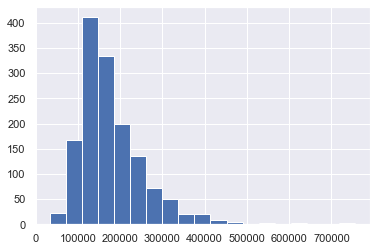

In [31]:
target = df['SalePrice']
bins = np.linspace(target.min(), target.max(), 20)
plt.rcParams['figure.figsize'] = 6,4
plt.hist(target, bins = bins);

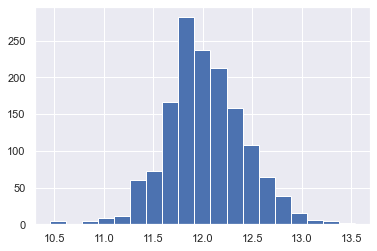

In [32]:
# Target variable is skewed in positive direction we can apply log transformation to bring it to normal distribtion
target = np.log1p(target)
bins = np.linspace(target.min(), target.max(), 20)
plt.rcParams['figure.figsize'] = 6,4
plt.hist(target, bins = bins);

#### Checking the skewness of the rest of the numeric variables


In [33]:
df.skew(axis=0).sort_values(ascending= False).head(10)

MiscVal          24.460085
PoolArea         15.948945
LotArea          12.573925
3SsnPorch        10.297106
LowQualFinSF      9.004955
KitchenAbvGr      4.484883
BsmtFinSF2        4.251925
ScreenPorch       4.118929
BsmtHalfBath      4.100114
EnclosedPorch     3.087164
dtype: float64

In [34]:
# All are skewed in positive direction Applying log2 transformation on them. To avoid log(0) we are going to 
# use numpy log1p
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_data = df[numeric_cols]
numeric_data = np.log1p(numeric_data)

#### Transforming categorical data into dummies

In [35]:
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
categorical_data = pd.get_dummies(df[categorical_cols], drop_first=True)
categorical_data.shape

(1458, 210)

#### Concatenate numeric and categorical data

In [36]:
# concatenate transformed data
data = np.concatenate([numeric_data, categorical_data], axis = 1)
data.shape

(1458, 247)

In [37]:
df.isnull().any().any()

False

#### split the data into train and test

In [38]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, random_state = 0, test_size=0.15)
Xtrain.shape, Xtest.shape

((1239, 247), (219, 247))

#### Model Training

In [39]:
## Applying Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
ypred = lin_reg.predict(Xtest)

In [41]:
print("MSE of Linear Regression = {:.3}".format(mean_squared_error(ytest, ypred)))
print("R2 coefficient for Linear Regression = {:.3}".format(r2_score(ytest, ypred)))

MSE of Linear Regression = 6.96e-27
R2 coefficient for Linear Regression = 1.0


#### Applying Regularization

In [42]:
# L2 Regularization
regu_lin_reg = Ridge()
regu_lin_reg.fit(Xtrain, ytrain)
ypred = regu_lin_reg.predict(Xtest)

In [43]:
print("MSE of Linear Regression = {:.3}".format(mean_squared_error(ytest, ypred)))
print("R2 coefficient for Linear Regression = {:.3}".format(r2_score(ytest, ypred)))

MSE of Linear Regression = 6.86e-05
R2 coefficient for Linear Regression = 1.0


#### Perform GridSearch

In [44]:
param_grid = {
    'alpha' : [1, 10, 100, 0.1, 0.01, 0.001, 0.0001],
    'max_iter' : [100, 500, 1000, 50]
}
predictors_grid = GridSearchCV(Ridge(), param_grid=param_grid, scoring='neg_mean_squared_error', cv = 10)

In [45]:
predictors_grid.fit(Xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1, 10, 100, 0.1, 0.01, 0.001, 0.0001],
                         'max_iter': [100, 500, 1000, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [46]:
predictors_grid.best_params_

{'alpha': 0.0001, 'max_iter': 100}

In [47]:
# L2 Regularization
regu_lin_reg = Ridge(alpha=1, max_iter=100)
regu_lin_reg.fit(Xtrain, ytrain)
ypred = regu_lin_reg.predict(Xtest)

In [48]:
print("MSE of Linear Regression = {:.3}".format(mean_squared_error(ytest, ypred)))
print("R2 coefficient for Linear Regression = {:.3}".format(r2_score(ytest, ypred)))

MSE of Linear Regression = 6.86e-05
R2 coefficient for Linear Regression = 1.0
